In [1]:
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
import numpy as np
import pickle
import string
import itertools

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import metrics

In [2]:
## Helper functions
#
## CONFUSION MATRIX ###

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## top10keywords from pipeline ##

def top10keys(pipe_model, classes):
    vectorizer = pipe_model.named_steps['vectorizer']
    clf = pipe_model.named_steps['clf']
    
    features_names = vectorizer.get_feature_names()
    feature_names = np.asarray(features_names)
    
    print("Top 10 keywords per class \n")
    for i, label in enumerate(classes):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (label, ", ".join(feature_names[top10])))
        
## predict and print all the stuff ##

def predict_and_win(classes_names):
    y_pred = pipe.predict(X_test)
    print('Classification Report: \n')
    print(metrics.classification_report(y_test, y_pred))
    print('='*60)
    print('Accuracy: {}'.format(metrics.accuracy_score(y_test,y_pred)))
    print('='*60)
    plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), classes=classes_names, title='Confusion matrix')


# Project 4: NLP, NLP, NLP

We will be doing all classification models and attempt to kill two ~~birds~~ questions with one ~~stone~~ classification model - which is Section 1 and the bonus section. However, I would require the answers to Section 2 before I am able to do Section 1 So, I won't be going through the project in the same order as the README file. Sorry...

## Bringing in my tables from SQL

In [3]:
connection = sqlite3.connect('job_scraped.db.sqlite')

In [4]:
sql_query = '''
SELECT *
FROM jobs
'''

In [5]:
df = pd.read_sql(sql_query, con=connection)

In [6]:
df.head()

,description,id,title
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst
2,What is the job ?\n\n\nThe role will involve m...,59df81c8a00dc826,Junior Data Analyst
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst


In [7]:
# Check for duplicates
df['id'].duplicated(keep='first').sum()

0

In [8]:
# Check for data entry jobs
df[df['title'].str.contains('Data Entry')]

,description,id,title


In [9]:
# Check for Internships
df[df['title'].str.contains('Internship')]

,description,id,title
17,"Expedia\n\nIf you are seeking a collaborative,...",b4360fcd5896614c,Internship – Singapore – Data Growth Analyst I...
19,In your new role you will:\nAssist analytics t...,7ea2500e814e660b,Internship - Data Analyst
169,Job Summary\n\nJob Title: Summer Internship 20...,a4be9d6531a5fd98,Summer Internship 2018
258,About Us:\nGE is the world's Digital Industria...,bf54a0408db5e412,Internship -Business Analyst- Healthcare (Jul ...
478,About Us:\nGE is the world's Digital Industria...,14533e4fd58270cf,Internship - Service Operations
497,About Us:\nGE is the world’s Digital Industria...,055cb0d9d8aa982c,GE Aviation Internship
521,In your role you will:\nBe involved in key pro...,207475703e8d5f08,Internship - Test Automation
534,In your new role you will\nBe involved in lots...,67081fd9c763ba0f,Internship - Product Test Engineering (Automat...
902,About the Role\n\n\nInformation Technology at ...,86b371ee515b345c,Artificial Intelligent Bot Engineer - Internship
1101,In your new role you will:\nStudy and assess c...,93c36bce0027be71,Internship - R&D Big Data Analysis using AI/ML


Hurray! No duplicates! and no data entry jobs. There are some internships, but let's leave them in and see what happens.

## 1) Data Scientists versus others
What components of a job posting distinguish data scientists from other data jobs?

### Data Scientist vs Data Analyst vs Data Engineer

In [10]:
# Extracting all jobs with "Data Science" in the title

only_ds = df[df['title'].isin(['Data Scientist','Junior Data Scientist','Senior Data Scientist'])].copy()
only_ds['label'] = 'DS'

In [11]:
only_da = df[df['title'].isin(['Data Analyst','Junior Data Analyst','Senior Data Analyst'])].copy()
only_da['label'] = 'DA'

In [12]:
only_de = df[df['title'].isin(['Data Engineer','Junior Data Engineer','Senior Data Engineer'])].copy()
only_de['label'] = 'DE'

In [13]:
ds_vs_others = pd.concat([only_ds,only_da,only_de], ignore_index=True)

# Dropping ID and Title because we don't need thouse anymore.
ds_vs_others.drop(columns=['id','title'], inplace=True)

In [14]:
ds_vs_others.head()

,description,label
0,PURPOSE OF THE ROLE\nThis role of a data scien...,DS
1,Work cross-functionally with business managers...,DS
2,Serve as primary source of data insights suppo...,DS
3,"Big data, artificial intelligence and advanced...",DS
4,As the innovation leader in the logistics indu...,DS


In [15]:
ds_vs_others['label'].value_counts()

DS    33
DE    25
DA    21
Name: label, dtype: int64

In [16]:
print('Baseline: {}'.format(1.0-(float(33)/float(33+25+21))))

Baseline: 0.582278481013


WOOT! I have a balanced dataset :) albeit small.... but let's see if we can infer anything from it using NLP.

### Simple cleaning, no stemming or lemmitization or removal of stop words because it is so small (rows = 60+).

In [17]:
# Removing punctuation, numbers and lowercase all
ds_vs_others['clean'] = ds_vs_others['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [18]:
ds_vs_others.head()

,description,label,clean
0,PURPOSE OF THE ROLE\nThis role of a data scien...,DS,purpose of the role this role of a data scient...
1,Work cross-functionally with business managers...,DS,work cross functionally with business managers...
2,Serve as primary source of data insights suppo...,DS,serve as primary source of data insights suppo...
3,"Big data, artificial intelligence and advanced...",DS,big data artificial intelligence and advanced...
4,As the innovation leader in the logistics indu...,DS,as the innovation leader in the logistics indu...


In [19]:
X = ds_vs_others['clean']
y = ds_vs_others['label']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', SGDClassifier(random_state=42))
])

In [22]:
model = pipe.fit(X_train, y_train)

C:\Users\ponzu\Anaconda3\envs\py27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [23]:
top10keys(model, classes=['DA', 'DE', 'DS'])

Top 10 keywords per class 

DA: clients, will, we, requirements, customer, development, reporting, product, sales, analyst
DE: we, engineering, etl, role, engineer, skill, you, management, of, data
DS: scientists, business, scientist, science, problems, research, machine, analytics, learning, models


Classification Report: 

             precision    recall  f1-score   support

         DA       0.33      0.50      0.40         6
         DE       0.71      0.71      0.71         7
         DS       0.88      0.64      0.74        11

avg / total       0.69      0.62      0.65        24

Accuracy: 0.625
Confusion matrix, without normalization
[[3 2 1]
 [2 5 0]
 [4 0 7]]


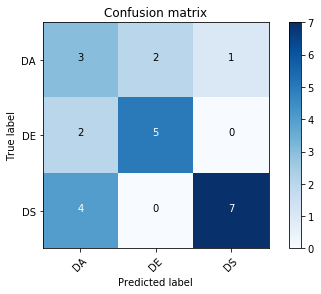

In [24]:
predict_and_win(['DA', 'DE', 'DS'])

Yup, as expected. Because DA's top 10 keywords had company names in the mix which of course will throw it off course quite fast and easily.

In [25]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', SGDClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

top10keys(model, classes=['DA', 'DE', 'DS'])

Top 10 keywords per class 

DA: planning, microsoft, reports, audit, clients, sales, customer, reporting, data analyst, analyst
DE: end, data, data warehousing, infrastructure, skill, warehousing, aws, pipelines, data engineer, engineer
DS: stakeholders, data scientist, scientist, data analytics, learning, machine learning, machine, models, research, analytics


Classification Report: 

             precision    recall  f1-score   support

         DA       0.60      0.50      0.55         6
         DE       1.00      0.71      0.83         7
         DS       0.71      0.91      0.80        11

avg / total       0.77      0.75      0.75        24

Accuracy: 0.75
Confusion matrix, without normalization
[[ 3  0  3]
 [ 1  5  1]
 [ 1  0 10]]


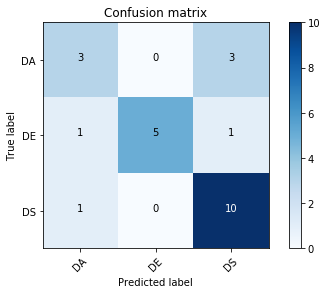

In [26]:
predict_and_win(['DA', 'DE', 'DS'])

At this point, I went back and scraped for company names. I just needed enough to add as stop words.

In [27]:
# Load in the pickled list of company names
with open('company_names.p','rb') as f:
    company_names = pickle.load(f)

In [28]:
# Remove duplicates
company_names = list(set(company_names))

# Turn into dataframe for easy removal of punctuation and lowercasing
company_df = pd.DataFrame({'companies': company_names})

In [29]:
company_names = company_df['companies'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower().split()).tolist()
company_names = [y for x in company_names for y in x]

In [30]:
# Remove duplicates
company_names = list(set(company_names))

# Add 'jll' because it is a real estate company and microsoft because .... microsoft
company_names.extend(['jll','microsoft'])

In [31]:
# Add to the stopwords list
stop_words1 = ENGLISH_STOP_WORDS.union(company_names)

In [32]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words1, ngram_range=(1,2))),
    ('clf', SGDClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

top10keys(model, classes=['DA', 'DE', 'DS'])

Top 10 keywords per class 

DA: report, great work, ability, audit, planning, reporting, clients, sales, data analyst, analyst
DE: infrastructure, engineering, end, data warehousing, skill, aws, warehousing, pipelines, data engineer, engineer
DS: fraud, algorithms, machine learning, stakeholders, learning, data scientist, scientist, machine, models, research


Classification Report: 

             precision    recall  f1-score   support

         DA       0.80      0.67      0.73         6
         DE       1.00      0.86      0.92         7
         DS       0.77      0.91      0.83        11

avg / total       0.84      0.83      0.83        24

Accuracy: 0.833333333333
Confusion matrix, without normalization
[[ 4  0  2]
 [ 0  6  1]
 [ 1  0 10]]


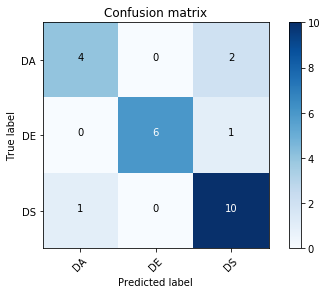

In [33]:
predict_and_win(['DA', 'DE', 'DS'])

In [34]:
# Let's do this with the ensemble method of the boosting family: GradientBoostingClassifier which is quite similar to the SGDClassifier 
# in that they both utilize Gradient Descent

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words1, ngram_range=(1,2))),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

Classification Report: 

             precision    recall  f1-score   support

         DA       1.00      0.67      0.80         6
         DE       1.00      1.00      1.00         7
         DS       0.85      1.00      0.92        11

avg / total       0.93      0.92      0.91        24

Accuracy: 0.916666666667
Confusion matrix, without normalization
[[ 4  0  2]
 [ 0  7  0]
 [ 0  0 11]]


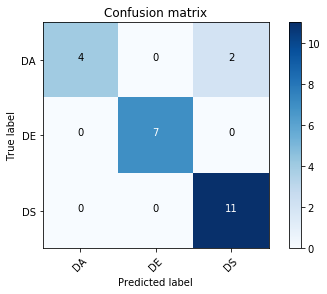

In [35]:
predict_and_win(['DA', 'DE', 'DS'])

### Conclusion

Removing company names (as much as possible) resulted in more mis-classifications of Data Analysts as Data Scientist, but less for the other way round. Without company names in the mix, the job description are close enough that there's a higher chance of mis-classification. This leads me to the following:

1. Some companies posts Data Scientists job titles but the job descriptions reads closer to a Data Analyst title.
2. Because I added Junior Data Scientists in the Data Scientist pool, perhaps that caused the mix of job description as Jr. Data Scientists tend to be Data Analysts.
3. Data Analyst did have the lowerest number of samples, so not too surprised that it wasn't able to catch them all. 
4. One can argue that Data Analysts and Data Scientist are in the same cluster as each other, as compared to Data Engineers. Throughout all iterations, DEs were well classified and accurately so, with one wrong one (each)

**Lesson:** It is possible to derive some insights from a small dataset, it is just very important to clean the data as much as possible and be mindful of the top10 words in both categories (don't remove too much and/or don't remove too little).



## 2) What features are important for distinguishing junior vs. senior positions?

Salary numbers: https://www.techinasia.com/data-scientist-salaries-singapore-revealed and https://www.payscale.com/ 

In [36]:
only_jr = df[df['title'].str.contains('Junior|Jr|Associate|Assoc|Executive|Exec|Entry')].copy()
only_jr['label'] = 'Jr'

In [37]:
only_sr = df[df['title'].str.contains('Senior|Sr')].copy()
only_sr['label'] = 'Sr'

In [38]:
jr_vs_sr = pd.concat([only_jr,only_sr], ignore_index=True)

# Dropping ID and Title because we don't need those anymore.
jr_vs_sr.drop(columns=['id','title'], inplace=True)

In [39]:
jr_vs_sr['label'].value_counts()

Sr    196
Jr    103
Name: label, dtype: int64

In [40]:
print('Baseline: {}'.format(float(196)/float(103+196)))

Baseline: 0.655518394649


In [41]:
jr_vs_sr.head()

,description,label
0,What is the job ?\n\n\nThe role will involve m...,Jr
1,About the Business Analyst position\n\nWe are ...,Jr
2,Contribute to the Revenue Optimization departm...,Jr
3,BlackRock helps investors build better financi...,Jr
4,The Company\nWillis Towers Watson is a leading...,Jr


In [42]:
jr_vs_sr['clean'] = jr_vs_sr['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [43]:
X = jr_vs_sr['clean']
y = jr_vs_sr['label']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('clf', SGDClassifier(random_state=42, class_weight='balanced'))
])

model = pipe.fit(X_train, y_train)

In [46]:
# Can't use top10 function because this is binary class
vectorizer = model.named_steps['vectorizer']
clf = model.named_steps['clf']

features_names = vectorizer.get_feature_names()
feature_names = np.asarray(features_names)

for i, label in enumerate(['Junior vs. Senior']):
    top10 = np.argsort(clf.coef_[0])[-10:]
    print("Top 10 keywords: %s" % (", ".join(feature_names[top10])))

Top 10 keywords: leadership, ensure, digital, project, business, oracle, lead, experience, science, senior


Classification Report: 

             precision    recall  f1-score   support

         Jr       0.64      0.71      0.68        35
         Sr       0.80      0.75      0.77        55

avg / total       0.74      0.73      0.74        90

Accuracy: 0.733333333333
Confusion matrix, without normalization
[[25 10]
 [14 41]]


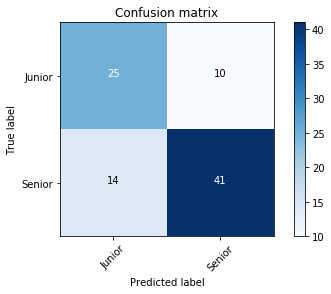

In [47]:
predict_and_win(['Junior','Senior'])

In [69]:
# Add 'responsibilities','requirements','relevant','years' to stop words
stop_words2 = stop_words1.union(['oracle','axa','edb','responsibilities','requirements','relevant','years','science','experience','advantage','phd','senior'])

In [70]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(2,2), max_df=0.8)),
    ('clf', SGDClassifier(random_state=42, class_weight='balanced'))
])

model = pipe.fit(X_train, y_train)

In [71]:
vectorizer = model.named_steps['vectorizer']
clf = model.named_steps['clf']

features_names = vectorizer.get_feature_names()
feature_names = np.asarray(features_names)

for i, label in enumerate(['Junior vs. Senior']):
    top10 = np.argsort(clf.coef_[0])[-10:]
    print("Top 10 keywords: %s" % (", ".join(feature_names[top10])))

Top 10 keywords: possess strong, roles utilizing, business analyst, sql server, degree computer, business problems, business process, ms sql, working knowledge, best practices


Classification Report: 

             precision    recall  f1-score   support

         Jr       0.63      0.63      0.63        35
         Sr       0.76      0.76      0.76        55

avg / total       0.71      0.71      0.71        90

Accuracy: 0.711111111111
Confusion matrix, without normalization
[[22 13]
 [13 42]]


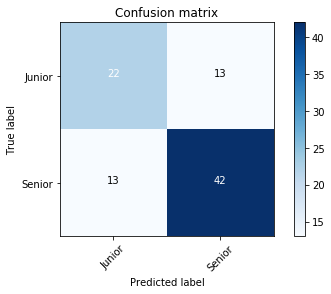

In [72]:
predict_and_win(['Junior','Senior'])

In [81]:
# Ensemble method here:

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(1,2), max_df=0.6)),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

Classification Report: 

             precision    recall  f1-score   support

         Jr       0.67      0.63      0.65        35
         Sr       0.77      0.80      0.79        55

avg / total       0.73      0.73      0.73        90

Accuracy: 0.733333333333
Confusion matrix, without normalization
[[22 13]
 [11 44]]


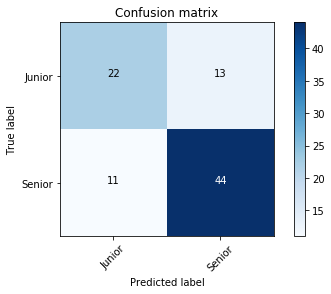

In [82]:
predict_and_win(['Junior','Senior'])

### Conclusion

Contrary to number (1), the ensemble method for this part performed as well as the non-ensemble method. This is perhaps due to more data. I am quite happy with 0.71 accuracy score here as I don't want it to overfit on this and it is an imbalanced dataset.

# 3)Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

In [54]:
# # initialize stemmer
# stemmer = SnowballStemmer('english')

# # stem each word
# print [stemmer.stem(word) for word in review.words]